In [11]:
from predictor_syn import *

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [14]:
predictor = MNISTTransform(args=None)
class_list = [0,1,2,3,4,5,6,7,8,9]  #for large number of class we need more complex model
X1,Y1 = predictor.generate_dataset(num_examples=6000,
                            class_list=class_list,
                            transformation="color",
                            transformation_param = "red",
)
# predictor.get_predictor(X1,Y1,class_list)

#Now getting the data from other domain
X2,Y2 = predictor.generate_dataset(num_examples=6000,
                            class_list=class_list,
                            transformation="color",
                            transformation_param = "green",
)
#Now training the debugger
predictor.remove_spurious_features_unsup(X1,Y1,X2,Y2,class_list,epochs=40)

Total Number of examples in dataset: 60000
Number of Example after Subset: (58862, 28, 28, 1)
Total Number of examples in dataset: 60000
Number of Example after Subset: (58862, 28, 28, 1)
#################################################
###########  Training the Debugger ##############
#################################################
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2704)              0         
___________________________________________________

230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0220 - pred_x: 2.0458 - causal_x: 0.1238 - spurious_x: 1.8392
Epoch 30/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0218 - pred_x: 2.0496 - causal_x: 0.1131 - spurious_x: 1.8332
Epoch 31/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0216 - pred_x: 2.2273 - causal_x: 0.1093 - spurious_x: 2.0359
Epoch 32/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0216 - pred_x: 2.3811 - causal_x: 0.1010 - spurious_x: 2.2204
Epoch 33/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0214 - pred_x: 2.4537 - causal_x: 0.0978 - spurious_x: 2.3832
Epoch 34/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0213 - pred_x: 2.4178 - causal_x: 0.0919 - spurious_x: 2.2495
Epoch 35/40
230/230 [==============================] - 4s 19ms/step - en_de_mse: 0.0212 - pred_x: 2.5729 - causal_x: 0.0995 - spurious_x: 2.61

## Full Decoding

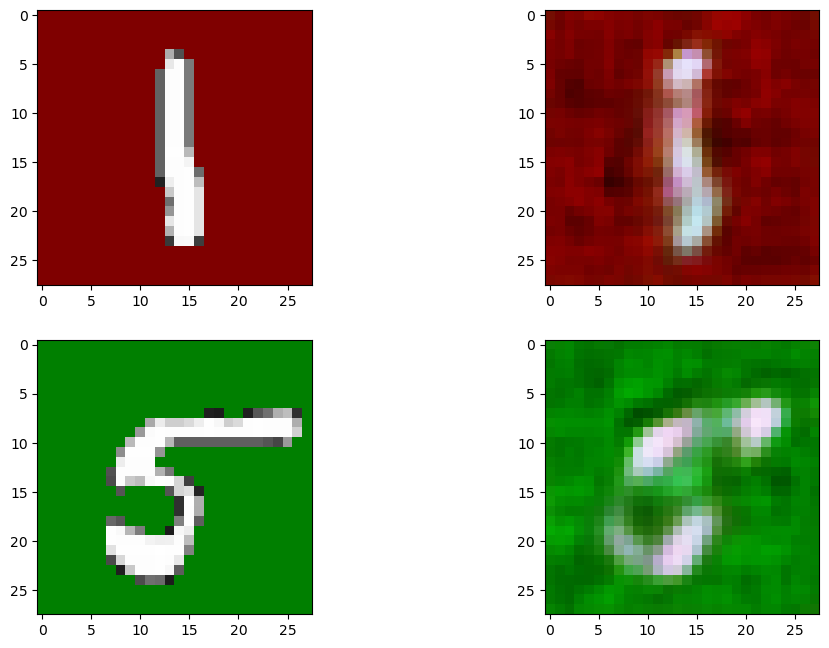

In [16]:
X = np.concatenate([X1,X2],axis=0)
rec_X1 = predictor.decoder(predictor.encoder(X)).numpy()
figure, axes = plt.subplots(2,2)

idx0 = 9423
axes[0,0].imshow(X[idx0,:,:,:],cmap="gray")
axes[0,1].imshow(rec_X1[idx0,:,:,:],cmap="gray")

idx1 = 89764
axes[1,0].imshow(X[idx1,:,:,:],cmap="gray")
axes[1,1].imshow(rec_X1[idx1,:,:,:],cmap="gray")

plt.show()

## Stable Decoding

In [17]:
def get_decoded_X(domain_X, domain_Y ,class_num):
    latent_space_dim = 7*7*2
    #Getting the encoded layer
    latent_X = predictor.encoder(domain_X).numpy()

    #Getting only causal latent representation
    only_causal_latent_X = latent_X.copy()
    only_causal_latent_X[:,latent_space_dim//2:] = 0

    #Getting only noise latent representation
    only_spurious_latent_X = latent_X.copy()
    only_spurious_latent_X[:,0:latent_space_dim//2] = 0 

    #Creading the causal feature for docding
    causal_X = predictor.decoder(only_causal_latent_X)
    spurious_X = predictor.decoder(only_spurious_latent_X)
    
    #Filtering for a particular class
    if class_num!=None:
        filter_arr = (domain_Y==class_num)
        
        domain_X = domain_X[filter_arr]
        causal_X = causal_X[filter_arr]
        spurious_X = spurious_X[filter_arr]
    
    return domain_X,causal_X,spurious_X

def plot_debugger_result(X1,Y1,X2,Y2,class_num):
    
    #Get the decoded data
    X1,causal_X1,spurious_X1 = get_decoded_X(X1,Y1,class_num)
    X2,causal_X2,spurious_X2 = get_decoded_X(X2,Y2,class_num)
    
    
    #Plotting the causal representation
    num_samples = 6
    figure, axes = plt.subplots(num_samples,6)

    imdxs = np.random.randint(0,causal_X1.shape[0],num_samples).tolist()
    for idx,imdx in enumerate(imdxs):
        axes[idx,0].imshow(X1[imdx,:,:,:],cmap="gray")
        axes[idx,1].imshow(causal_X1[imdx,:,:,:],cmap="gray")
        axes[idx,2].imshow(spurious_X1[imdx,:,:,:],cmap="gray")
        
        axes[idx,3].imshow(X2[imdx,:,:,:],cmap="gray")
        axes[idx,4].imshow(causal_X2[imdx,:,:,:],cmap="gray")
        axes[idx,5].imshow(spurious_X2[imdx,:,:,:],cmap="gray")
    plt.show()

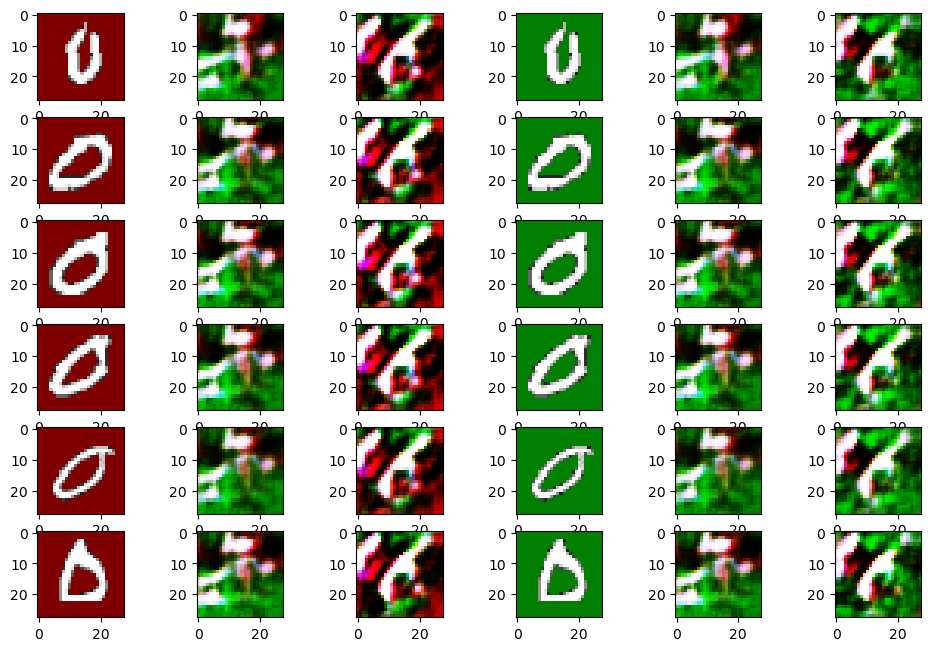

In [19]:
plot_debugger_result(X1,Y1,X2,Y2,0)

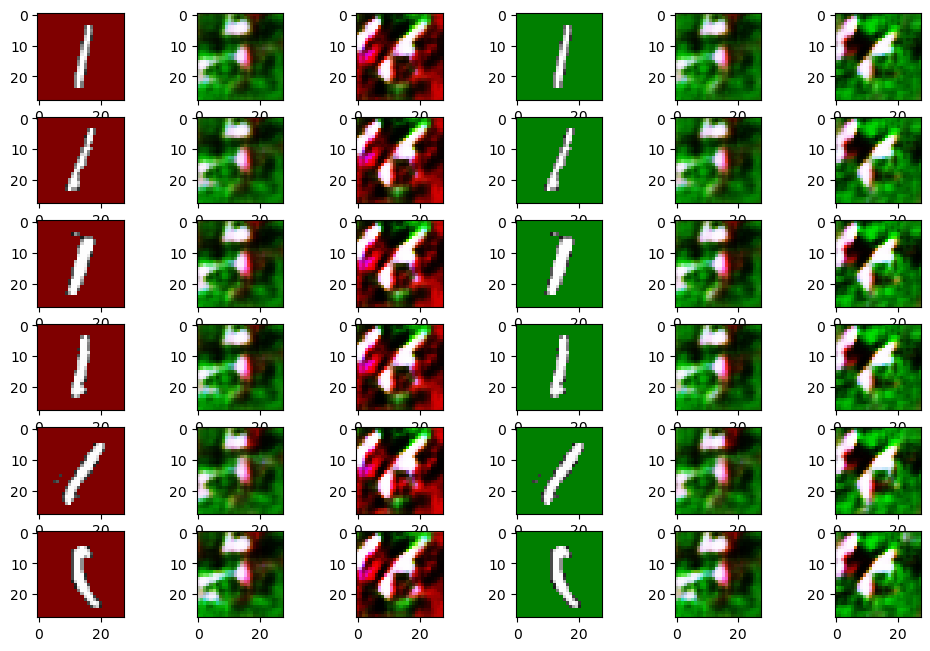

In [20]:
plot_debugger_result(X1,Y1,X2,Y2,1)

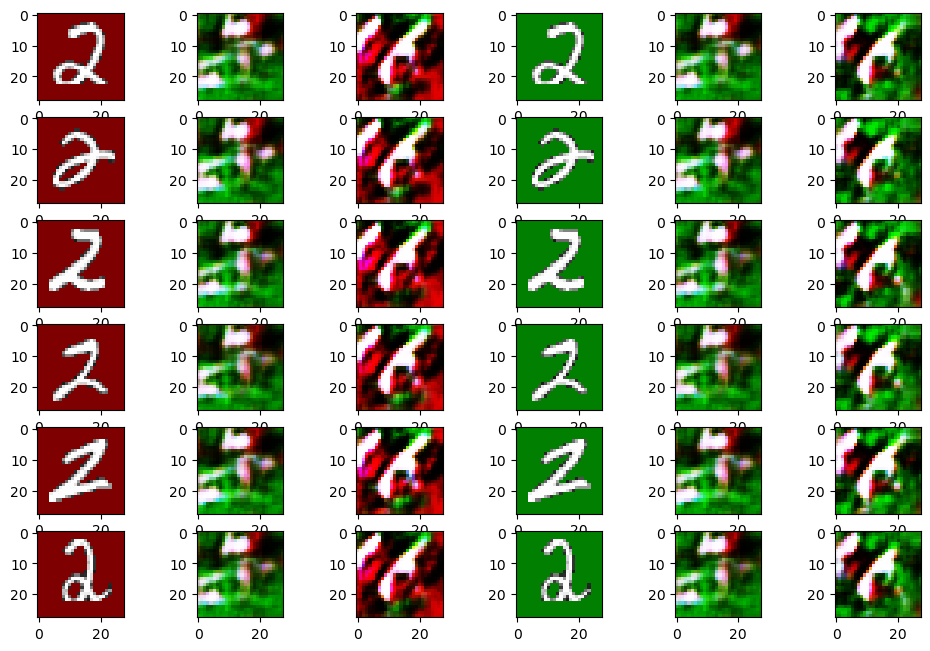

In [21]:
plot_debugger_result(X1,Y1,X2,Y2,2)

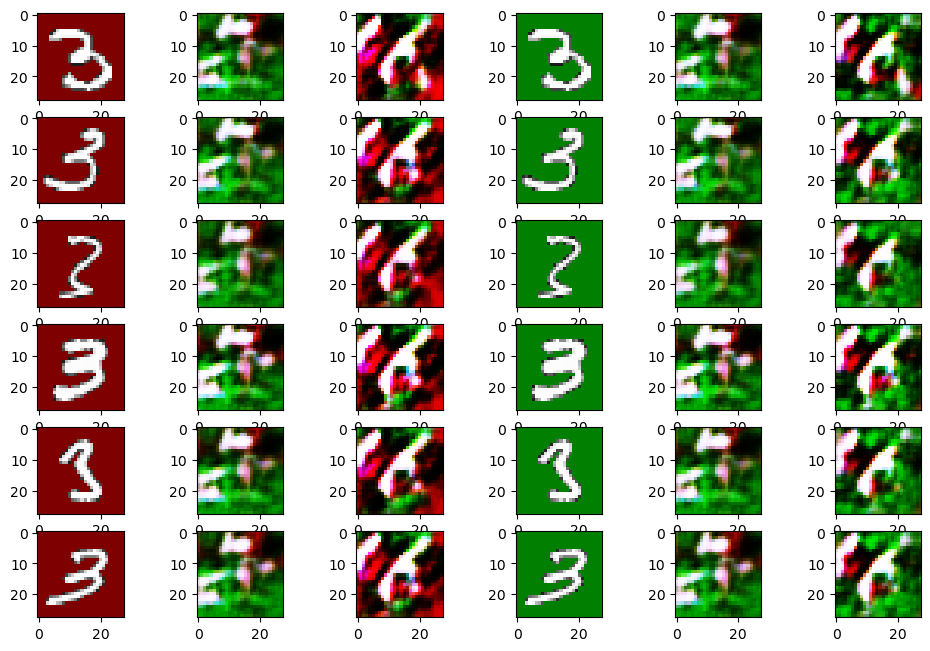

In [22]:
plot_debugger_result(X1,Y1,X2,Y2,3)

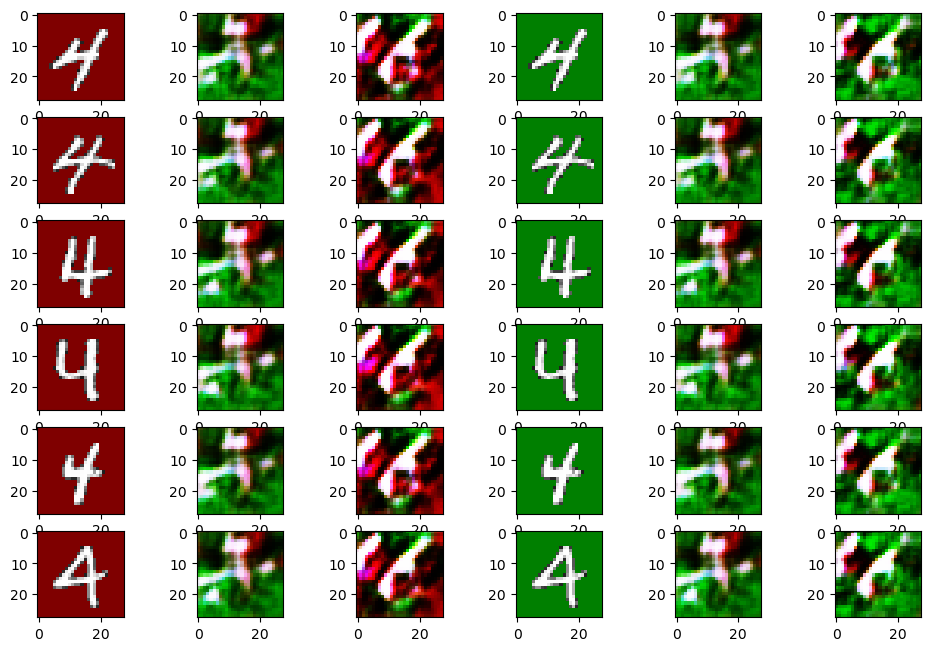

In [23]:
plot_debugger_result(X1,Y1,X2,Y2,4)

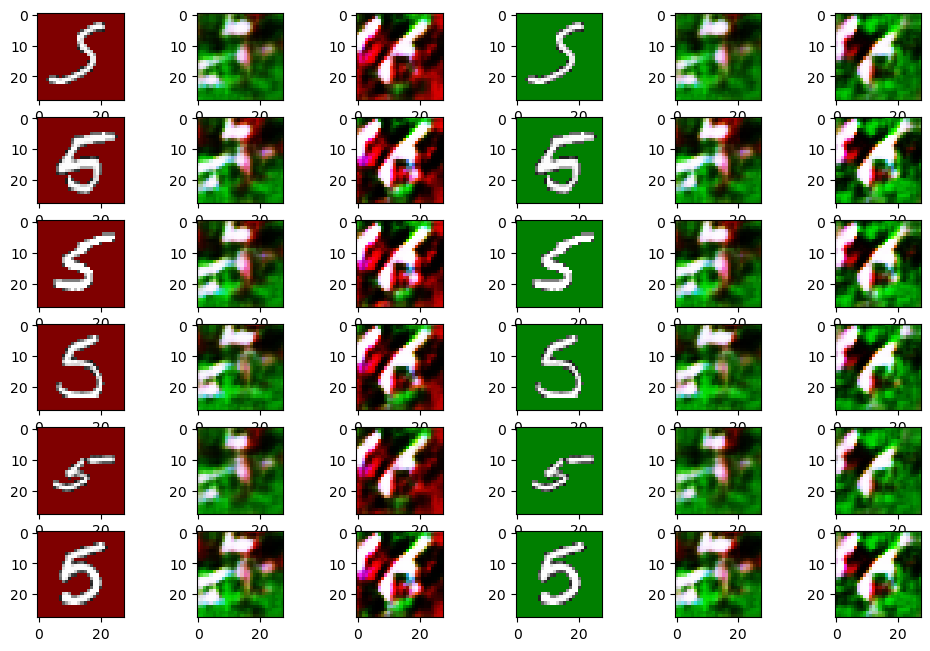

In [24]:
plot_debugger_result(X1,Y1,X2,Y2,5)

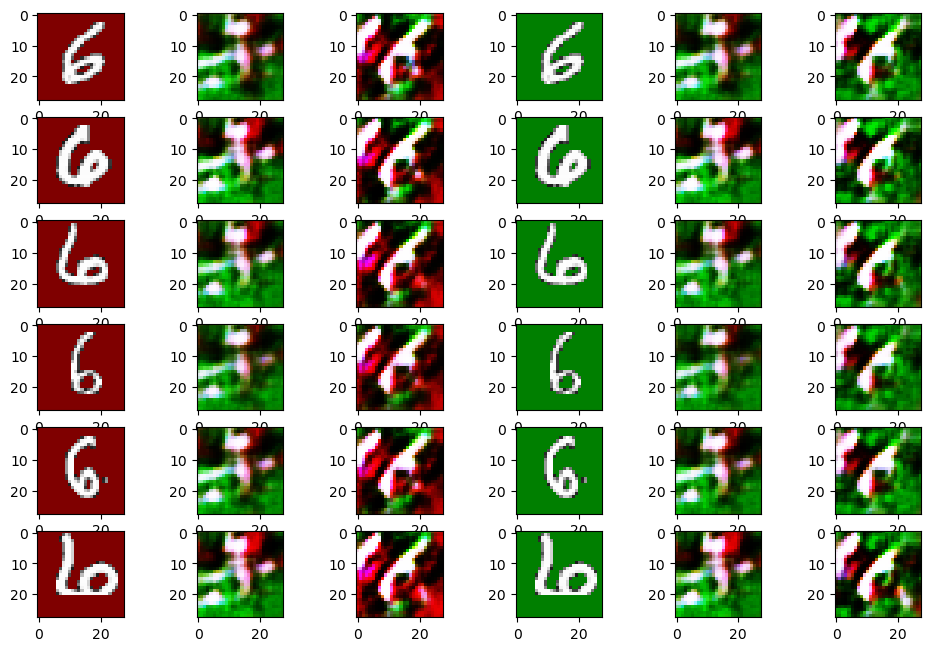

In [25]:
plot_debugger_result(X1,Y1,X2,Y2,6)

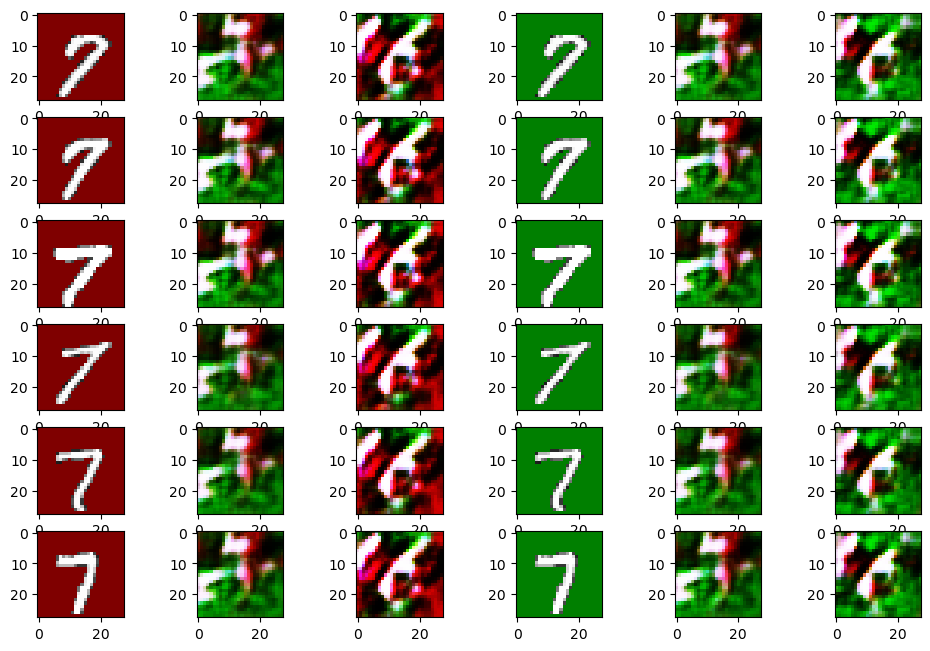

In [26]:
plot_debugger_result(X1,Y1,X2,Y2,7)

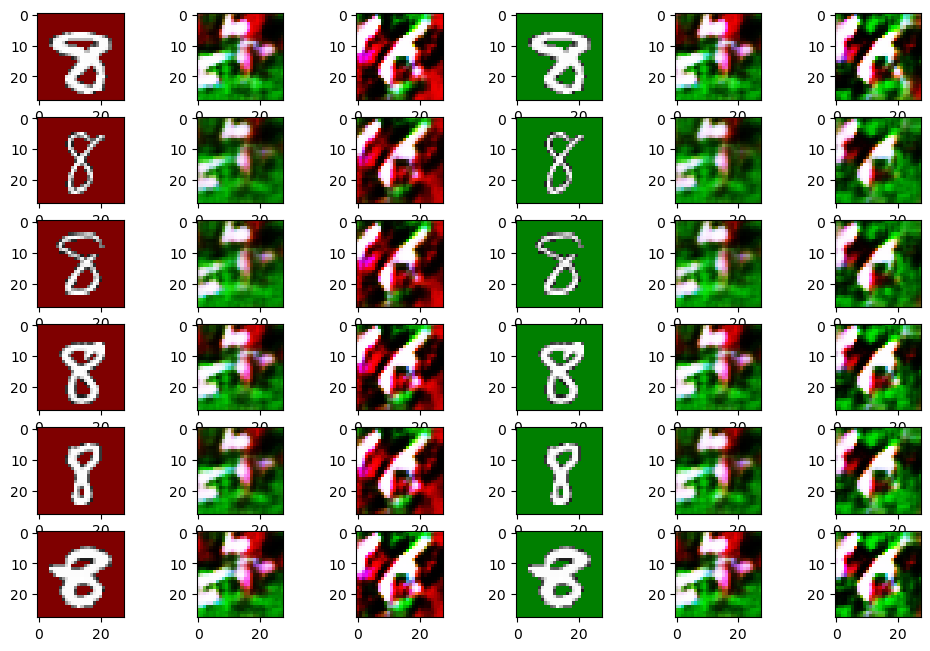

In [27]:
plot_debugger_result(X1,Y1,X2,Y2,8)

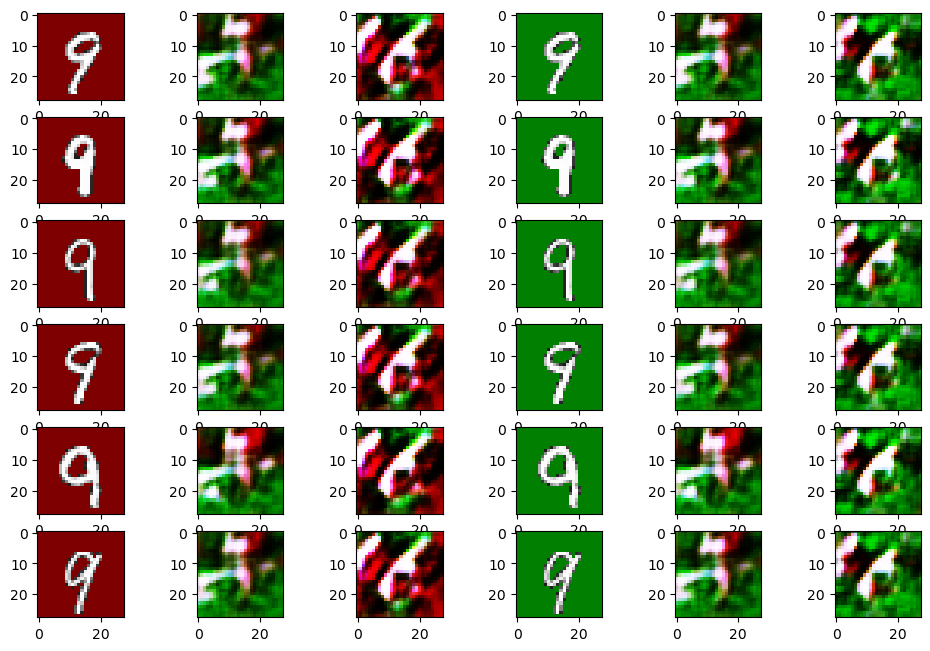

In [28]:
plot_debugger_result(X1,Y1,X2,Y2,9)